In [106]:
%load_ext autoreload
%autoreload 2
import barcoderegression
import pickle
import numpy as np
import matplotlib.pylab as plt
import scipy as sp
import scipy.ndimage
import tqdm.notebook
import numpy.random as npr
import ipywidgets
import skimage
import skimage.feature

from barcoderegression.plotting import AnimAcross

%matplotlib inline

def rbyc(A):
    mx=A.max()
    with AnimAcross(columns=A.shape[-1]) as a:
        for c in range(A.shape[-2]):
            for r in range(A.shape[-1]):
                ~a
                mappable=plt.imshow(A[:,:,c,r],vmin=0,vmax=mx)
                a.cb(mappable)
                plt.axis('off')
    
def rbycs(*args):
    def go(i):
        rbyc(args[i])
    ipywidgets.interact(go,i=list(range(len(args))))
    
def frames(model):
    frame_loadings=model.frame_loadings()
    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(frame_loadings[:,:,j]))
            plt.axis('off')

def spatials(model,spdims,blurred=True):
    F = model.F_scaled(blurred=blurred)

    with AnimAcross() as a:
        for j in range(model.J):
            a(j)
            a.cb(plt.imshow(F[:,j].reshape(spdims)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# simulate data

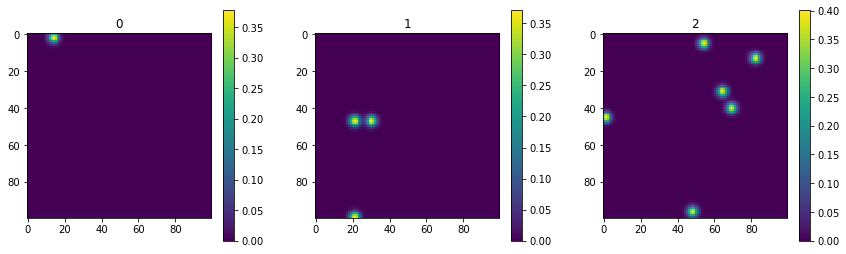

In [77]:
spdims=(100,100)
R=6
C=4
J=3

model,X,X_without_noise = barcoderegression.simulations.simulation(
    R=R,C=C,J=J,spatial_dims=spdims,
    num_spots=10,blursize=[2,2],noise=.005,rho=npr.rand(C),anoise=.01,bnoise=.01,lam=.005)

spatials(model,spdims)

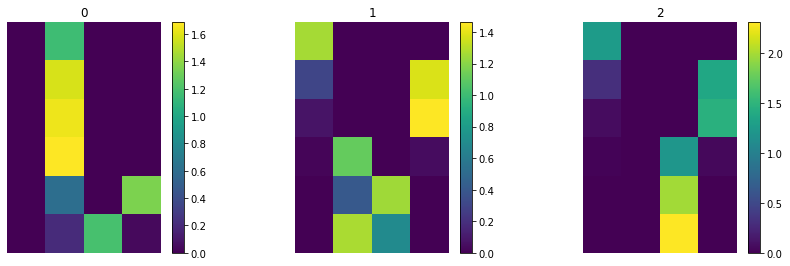

In [78]:
frames(model)

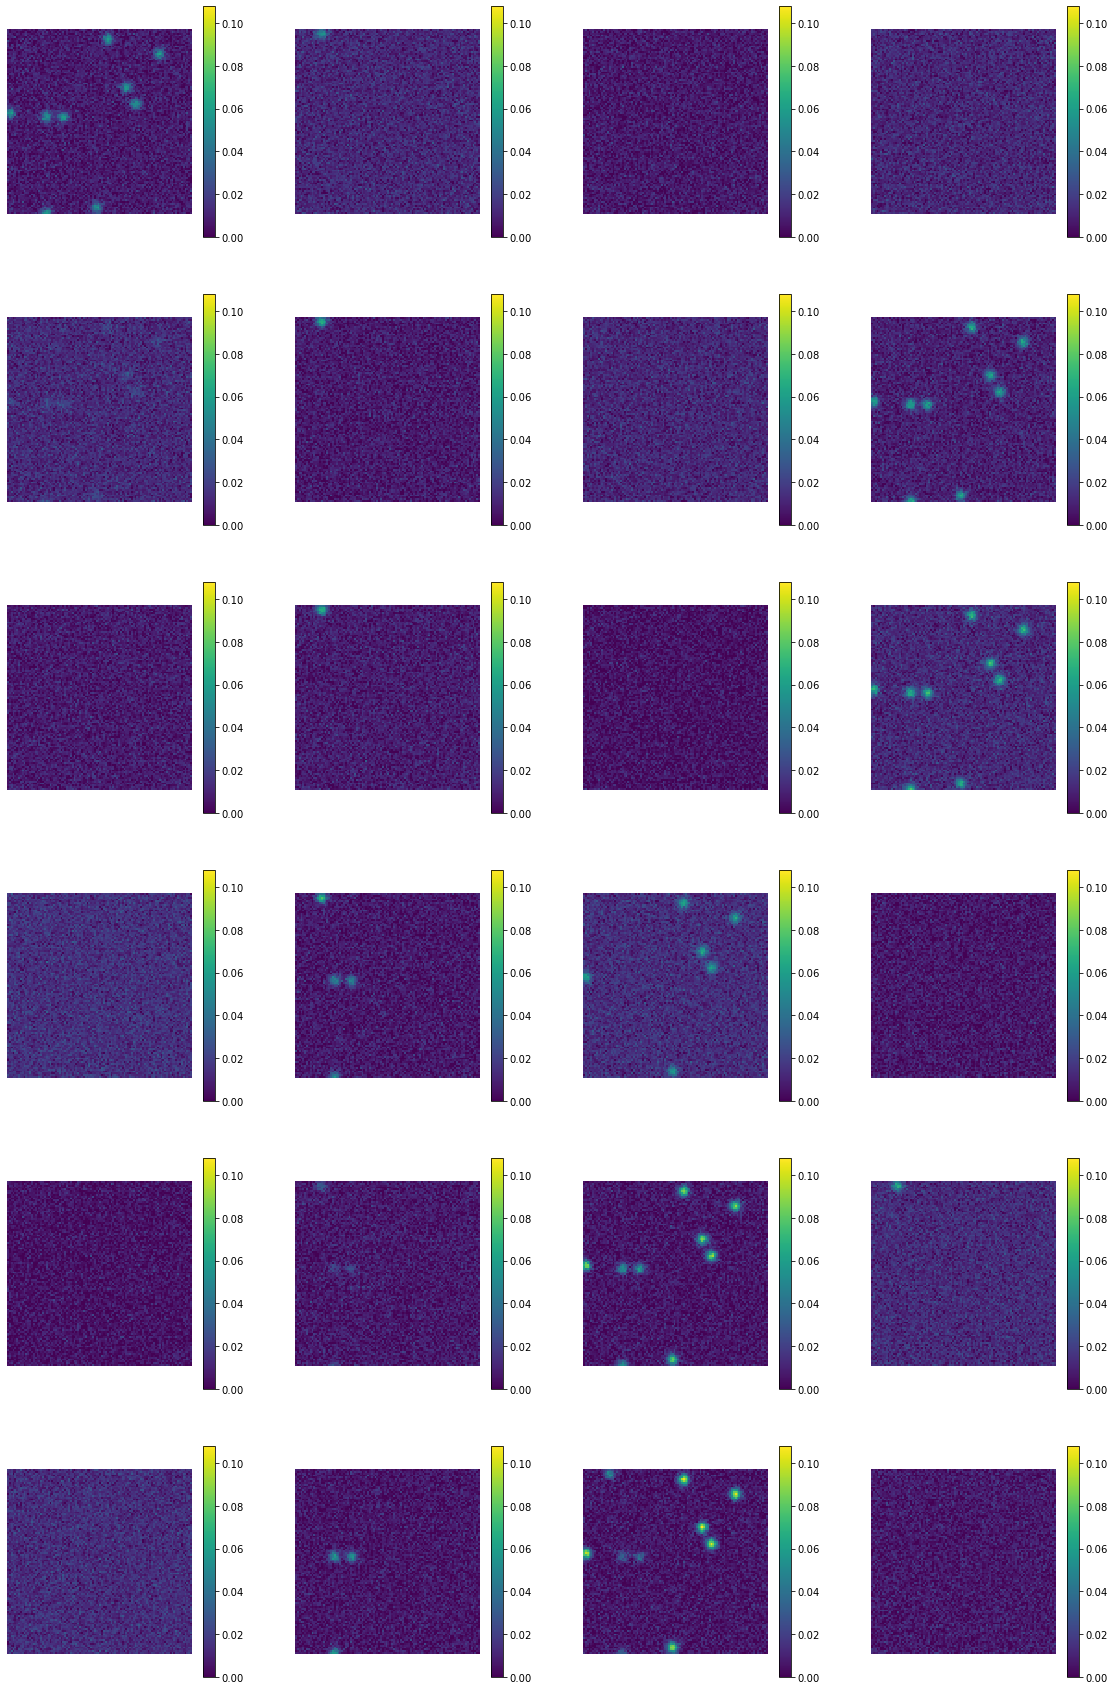

In [79]:
rbyc(X)

In [80]:
Xrav=X.reshape((-1,R,C))
lossinfo=model.loss(Xrav)
bestloss=lossinfo['loss']
print('true reconstruction loss',lossinfo['reconstruction'])
print('true L1 loss',model.lam*lossinfo['l1'])
print('true loss',lossinfo['loss'])

true reconstruction loss 2.9921260448307723
true L1 loss 0.45207498556095493
true loss 1.4350837626632196e-05


# try to learn loadings


we never went the wrong way!
final reconstruction loss 2.9356860527188573
final L1 loss 0.32737187343550017
final loss 1.3596074692309824e-05


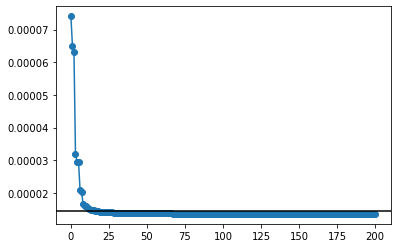

In [81]:
# model2=model.copy()
model2=barcoderegression.parameters.Model(model.B,model.K,M=model.M,lam=model.lam)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(40)):
    trainer.update(nms=['F','alpha','b','a','rho'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')
plt.axhline(bestloss,color='black')

lossinfo=model2.loss(Xrav)
print('final reconstruction loss',lossinfo['reconstruction'])
print('final L1 loss',model2.lam*lossinfo['l1'])
print('final loss',lossinfo['loss'])

In [82]:
bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

In [83]:
print(model2.rho,model.rho)

[0.         0.00449707 0.44163886 0.        ] [0.24208355 0.34668895 0.58651805 0.0327521 ]


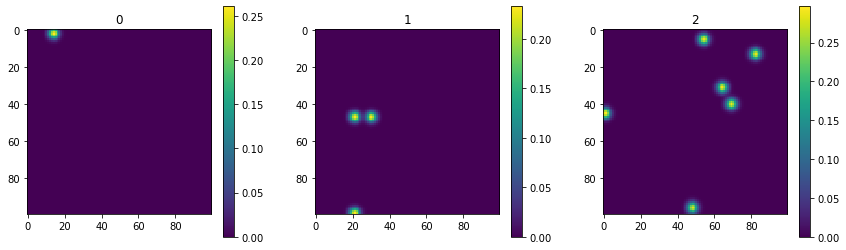

In [84]:

spatials(model2,spdims)

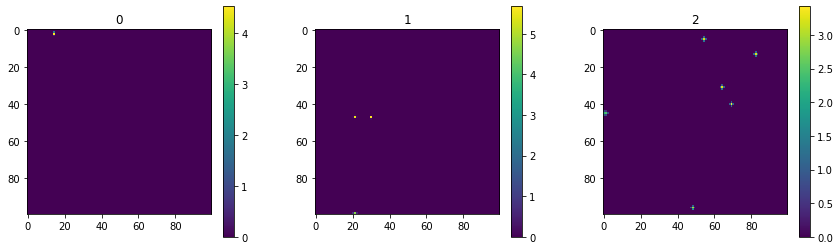

In [85]:

spatials(model2,spdims,blurred=False)

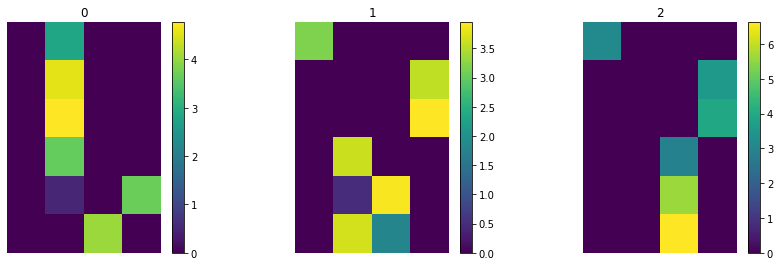

In [86]:
frames(model2)

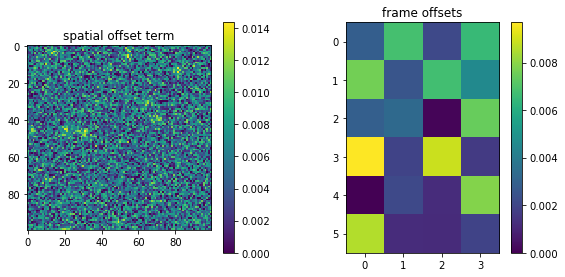

In [87]:
with AnimAcross() as a:
    a("spatial offset term")
    a.cb(plt.imshow(model2.a.reshape(spdims)))
    
    a('frame offsets')
    a.cb(plt.imshow(model2.b))

In [88]:
recon=model2.reconstruction().reshape(X.shape)
rbycs(recon,X)

interactive(children=(Dropdown(description='i', options=(0, 1), value=0), Output()), _dom_classes=('widget-int…

# try on real data

In [89]:
with open("example.pkl",'rb') as f:
    example=pickle.load(f)
    X=example['data'].transpose([2,3,0,1])
    B=example['barcode'].astype(np.bool)
    R=X.shape[-2]
    C=X.shape[-1]
    Xrav=X.reshape((-1,R,C))


we never went the wrong way!
final perpix reconstruction loss 0.16146494459879754
final perpix L1 loss 0.10163778672537503
final loss 0.26310273132417256


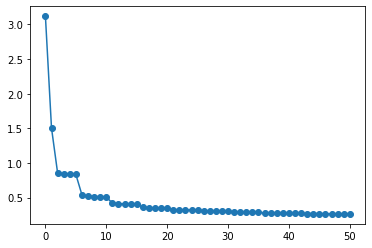

In [100]:
M=np.prod(X.shape[:-2])
model2=barcoderegression.parameters.Model(
    B,
    barcoderegression.blurkernels.ContiguousBlur(X.shape[:2],[1,1]),
    M=M,
    rho=np.ones(C)*.05,
    lam=.1)

trainer=barcoderegression.training.Trainer(X,model2)
for i in tqdm.notebook.tqdm(range(10)):
    trainer.update(nms=['F','alpha','b','a','rho'])

overall_losses=[x['loss'] for x in trainer.losses]
worst=np.diff(overall_losses).max()
if worst<=0:
    print("we never went the wrong way!")
else:
    print("we went wrong way",worst)
plt.plot(overall_losses,'-o')

lossinfo=model2.loss(Xrav)
print('final perpix reconstruction loss',lossinfo['reconstruction']/(R*C*M))
print('final perpix L1 loss',model2.lam*lossinfo['l1']/(R*C*M))
print('final loss',lossinfo['loss'])

In [102]:
bads=[x for x in trainer.losses if x['improvement']<0]
for b in bads:
    print(b['action'],b['reconstruction'],b['improvement'])

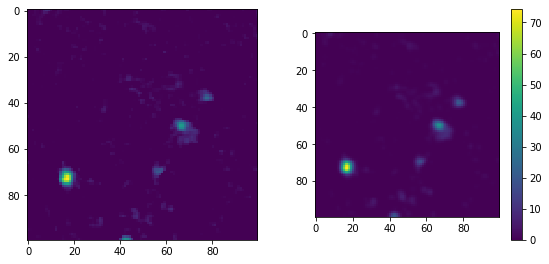

In [103]:
with AnimAcross() as a:
    ~a
    F=model2.F_scaled(blurred=False)
    plt.imshow(F[:,23].reshape(X.shape[:2]))
    ~a
    F=model2.F_scaled(blurred=True)
    a.cb(plt.imshow(F[:,23].reshape(X.shape[:2])))

In [122]:
F=model2.F_scaled(blurred=False).reshape(X.shape[:2]+(model2.J,))
def go(idx,thresh):
    plt.imshow(F[:,:,idx])
    peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=thresh)
    plt.colorbar()
    plt.axis("off")
    plt.scatter(peaks[:,1],peaks[:,0],marker='x',color='red')
    plt.title(f"{len(peaks)} peaks")
    
ipywidgets.interact(go,idx=list(range(model2.J)),thresh=(1,70))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.go(idx, thresh)>

In [163]:
THRESH=22
idx=23
allpeaks=[]
for idx in range(model2.J):
    peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=THRESH)
    peaks=np.c_[np.ones(len(peaks))*idx,peaks]
    allpeaks.append(peaks)
allpeaks=np.concatenate(allpeaks,axis=0)

In [166]:
# good=np.where(model2.B[1,3]*model2.B[2,1])[0]
# allpeaks=[x for x in allpeaks if (x[0] in good)]

good=np.where(model2.B[0,2]*model2.B[1,0]*model2.B[2,3])[0]
allpeaks=[x for x in allpeaks if (x[0] in good)]

In [168]:
allpeaks[2]

array([43., 89., 49.])

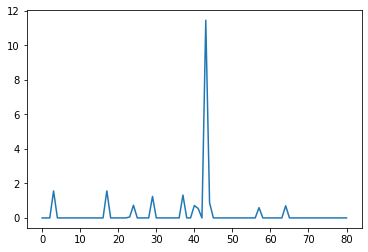

In [172]:
plt.plot(model2.F.reshape(X.shape[:2]+(model2.J,))[89,49])

In [167]:
F=model2.F_scaled(blurred=False).reshape(X.shape[:2]+(model2.J,))
def go(idx,radius):
    gene,x,y=allpeaks[idx]
    gene=int(gene)
    st=np.max([[0,0],[x-radius,y-radius]],axis=0)
    en=np.min([np.r_[X.shape[:2]],[x+radius+1,y+radius+1]],axis=0)
    sl=tuple([slice(int(a),int(b)) for (a,b) in zip(st,en)])
    with AnimAcross(columns=model2.C,sz=2) as a:
        for r in range(model2.R):
            for c in range(model2.C):
                ~a
                plt.imshow(X[sl+(r,c)],vmin=0,vmax=X[:,:,r,c].max())
                plt.axhline(radius,color='red')
                plt.axvline(radius,color='red')
                plt.axis("off")
                if model2.B[r,c,gene]:
                    plt.plot([radius],[radius],'rx',ms=20)
        
#     peaks=skimage.feature.peak_local_max(F[:,:,idx],threshold_abs=thresh)
#     plt.colorbar()
#     plt.axis("off")
#     plt.scatter(peaks[:,1],peaks[:,0],marker='x',color='red')
#     plt.title(f"{len(peaks)} peaks")
    
ipywidgets.interact(go,idx=list(range(len(allpeaks))),radius=[20,10])

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(d…

<function __main__.go(idx, radius)>

In [136]:
%debug

> /opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py(90)_wrapreduction()
     88                 return reduction(axis=axis, out=out, **passkwargs)
     89 
---> 90     return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
     91 
     92 

ipdb> up
> /opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py(2793)amin()
   2791     """
   2792     return _wrapreduction(a, np.minimum, 'min', axis, None, out,
-> 2793                           keepdims=keepdims, initial=initial, where=where)
   2794 
   2795 

ipdb> up
> <__array_function__ internals>(6)amin()

ipdb> up
> <ipython-input-135-f6f8ad5f472b>(4)go()
      2 def go(idx,radius):
      3     gene,x,y=allpeaks[idx]
----> 4     st=np.min([0,0],[x-radius,y-radius])
      5     en=np.max(np.r_[X.shape],[x+radius+1,y+radius+1])
      6     sl=tuple([slice(a,b) for (a,b) in zip(st,en)])

ipdb> x
88.0
ipdb> y
70.0
ipdb> radius
10
ipdb> quit


In [128]:
peaks

array([[23., 73., 17.],
       [23., 70., 57.],
       [23., 50., 66.],
       [23., 38., 77.]])

# learn stuff

In [ ]:
barcoderegression.parameters.Barcode

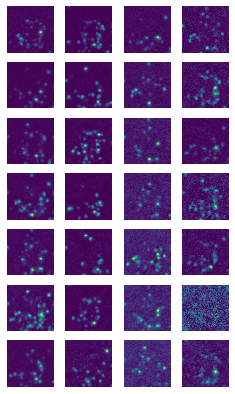

In [16]:

nby4(data)

In [9]:
data.shape

(7, 4, 100, 100)